In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys

curr_path = !pwd
curr_path = curr_path[0] + "/"
curr_path

'/content/'

In [3]:
utils_path = os.path.join(os.path.dirname(curr_path), 'drive', 'MyDrive', 'cmpt420_project', 'src', 'utils/')
utils_path

'/content/drive/MyDrive/cmpt420_project/src/utils/'

In [4]:
sys.path.append(utils_path)

In [5]:
img_path = os.path.join(os.path.dirname(curr_path), 'drive', 'MyDrive', 'CelebA', 'Img', 'img_align_celeba.zip')
img_path

'/content/drive/MyDrive/CelebA/Img/img_align_celeba.zip'

In [6]:
data_path = os.path.join('/tmp', 'dataset/')
data_path

'/tmp/dataset/'

### Unzipping dataset

In [7]:
if (os.path.exists(data_path)) == False:
  !mkdir {data_path}

In [8]:
# import zipfile

if os.path.exists(os.path.join(os.path.dirname(data_path), 'img_align_celeba')) == False:
  !unzip {img_path} -d {data_path}


Streaming output truncated to the last 5000 lines.
 extracting: /tmp/dataset/img_align_celeba/197600.jpg  
 extracting: /tmp/dataset/img_align_celeba/197601.jpg  
 extracting: /tmp/dataset/img_align_celeba/197602.jpg  
 extracting: /tmp/dataset/img_align_celeba/197603.jpg  
 extracting: /tmp/dataset/img_align_celeba/197604.jpg  
 extracting: /tmp/dataset/img_align_celeba/197605.jpg  
 extracting: /tmp/dataset/img_align_celeba/197606.jpg  
 extracting: /tmp/dataset/img_align_celeba/197607.jpg  
 extracting: /tmp/dataset/img_align_celeba/197608.jpg  
 extracting: /tmp/dataset/img_align_celeba/197609.jpg  
 extracting: /tmp/dataset/img_align_celeba/197610.jpg  
 extracting: /tmp/dataset/img_align_celeba/197611.jpg  
 extracting: /tmp/dataset/img_align_celeba/197612.jpg  
 extracting: /tmp/dataset/img_align_celeba/197613.jpg  
 extracting: /tmp/dataset/img_align_celeba/197614.jpg  
 extracting: /tmp/dataset/img_align_celeba/197615.jpg  
 extracting: /tmp/dataset/img_align_celeba/197616.jpg

### Importing Dependencies

In [49]:
import torch
import torchvision
import numpy as np
from DataLoader import CelebADataset
from PruningHelper import PruningHelper as ph
from HybridResNetVIT import HybridResNetVIT
from torch.utils.data import random_split, DataLoader, Subset

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [51]:
SAMPLE_SEED = 42
K_FOLDS = 4
EPOCHS = 5

BATCH_SIZE = 256

In [52]:
# att_path = f"../../../dataset/Anno/list_attr_celeba.txt"
att_path = os.path.join(os.path.dirname(curr_path), 'drive', 'MyDrive', 'cmpt420_project', 'dataset', 'Anno', 'list_attr_celeba.txt')

dataset = CelebADataset(os.path.join(os.path.dirname(data_path), 'img_align_celeba'), att_path)

In [53]:
TOTAL_SIZE = len(dataset)
TOTAL_SIZE

202599

#### Dataset split:

In [54]:
# SAMPLE_SIZE = int(TOTAL_SIZE * 0.5)
# SAMPLE_SIZE

In [55]:
test_size = int(0.1 * TOTAL_SIZE)
train_size = TOTAL_SIZE - test_size

# Generator
generator = torch.Generator().manual_seed(SAMPLE_SEED)

# TODO: USE THIS FOR FULL TRAINING
# Data split
indices = torch.randperm(len(dataset))
ds_train, ds_test = random_split(dataset, [train_size, test_size], generator=generator)

print(f"Train size: {len(ds_train)}, Test size: {len(ds_test)}")

Train size: 182340, Test size: 20259


In [56]:
train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=False)

In [57]:
from ModelUtils import ModelUtils
mu = ModelUtils(device)

### Initializing model

In [58]:
full_model = torch.load(f'/content/drive/MyDrive/full_model_04_07_2025_01_07.pth', weights_only=False)
pruned_resnet = torch.load(f'/content/drive/MyDrive/pruned_model_04_07_2025_01_07.pth', weights_only=False)

In [59]:
test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)
len(test_loader)

80

In [60]:
mu.test_model(pruned_resnet, test_loader)

Test Evaluation
Accuracy: 0.95
Test precision: 0.83
Test recall: 0.80
Test f1-score: 0.81
Finished test evaluation!


In [61]:
# Freeze resnet params
resnet_params = 0
for param in pruned_resnet.parameters():
    param.requires_grad = False
    resnet_params += 1
resnet_params

62

### Initialization of ViT Hybrid

In [62]:
model = HybridResNetVIT(resnet=pruned_resnet, num_layers=2).to(device)

In [63]:
total_param = 0
active_param = 0
for p in model.parameters():
    if p.requires_grad:
        active_param +=1
    total_param += 1

# Only those from the VIT encoder should be active total - 60.
total_param, active_param

(86, 26)

In [64]:
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=0.001
)

In [65]:
vit_pruned, vit_loss, vit_accuarcy, vit_precision, vit_recall, vit_f1_score = mu.trainer(model, optimizer, ds_train, K_FOLDS, BATCH_SIZE, EPOCHS)

Fold: 1, Epoch: [1/5], Loss: 0.0182870
Fold: 1, Epoch: [2/5], Loss: 0.0158393
Fold: 1, Epoch: [3/5], Loss: 0.0296146
Fold: 1, Epoch: [4/5], Loss: 0.0146152
Fold: 1, Epoch: [5/5], Loss: 0.0143537
Fold: [1/4], Accuracy: 0.9956564659427444, Precision: 0.99, Recall: 0.98, F1-Score: 0.99
Fold: 2, Epoch: [1/5], Loss: 0.0139813
Fold: 2, Epoch: [2/5], Loss: 0.0145237
Fold: 2, Epoch: [3/5], Loss: 0.0137673
Fold: 2, Epoch: [4/5], Loss: 0.0145336
Fold: 2, Epoch: [5/5], Loss: 0.0142622
Fold: [2/4], Accuracy: 0.9959855215531425, Precision: 0.99, Recall: 0.98, F1-Score: 0.99
Fold: 3, Epoch: [1/5], Loss: 0.0136855
Fold: 3, Epoch: [2/5], Loss: 0.0139469
Fold: 3, Epoch: [3/5], Loss: 0.0135635
Fold: 3, Epoch: [4/5], Loss: 0.0139844
Fold: 3, Epoch: [5/5], Loss: 0.0138776
Fold: [3/4], Accuracy: 0.9955467807392783, Precision: 0.98, Recall: 0.99, F1-Score: 0.99
Fold: 4, Epoch: [1/5], Loss: 0.0135413
Fold: 4, Epoch: [2/5], Loss: 0.0133234
Fold: 4, Epoch: [3/5], Loss: 0.0125394
Fold: 4, Epoch: [4/5], Loss: 0.

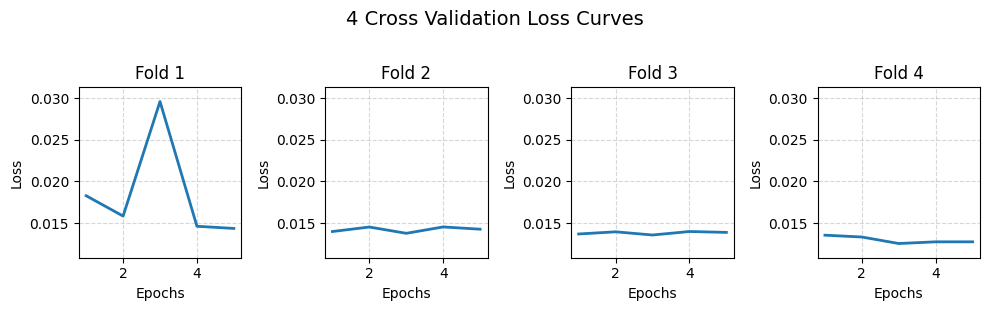

In [66]:
mu.plot_loss_curves(vit_loss, K_FOLDS, EPOCHS)

In [67]:
ph.get_sparsity(vit_pruned)

63.2658055990879

In [68]:
mu.test_model(vit_pruned, test_loader)

Test Evaluation
Accuracy: 0.95
Test precision: 0.82
Test recall: 0.82
Test f1-score: 0.82
Finished test evaluation!


In [69]:
from datetime import datetime

current_time = datetime.now().strftime("%m_%d_%Y_%H_%M")
torch.save(vit_pruned, f'/content/drive/MyDrive/vit_pruned{current_time}.pth')